In [18]:
import cv2
from pathlib import Path

from robustpca.general import ROOT_DIR

In [20]:
yale_data_dir  = Path(ROOT_DIR, 'data', 'CroppedYale')
assert yale_data_dir.exists()

In [36]:
human_id = 0

faces = []
for face_path in sorted(list(yale_data_dir.glob('*'))[human_id].glob('*.pgm'))[:-1]:
    arr = cv2.imread(face_path.as_posix())[:, :, 0]
    faces.append(arr)

In [38]:
len(faces)

64

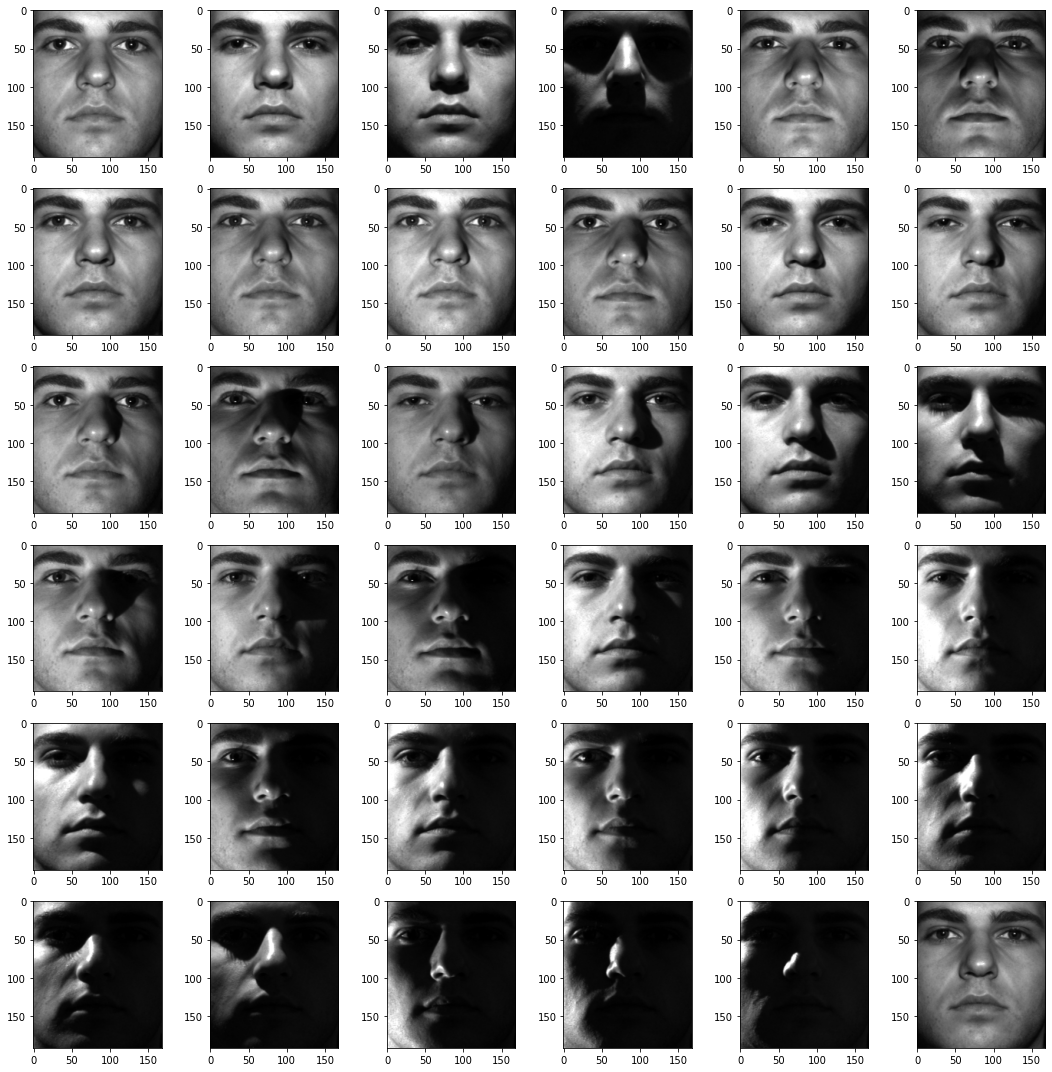

In [39]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(6, 6, figsize=(15, 15))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(faces[i], cmap='gray')

fig.tight_layout()